# This notebook contains the script to perform transfer learning on the Deep CNN trained on the minerals dataset. The first 2 layers of the Deep CNN are used as feature extractors.  

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch import tanh
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, BatchNorm1d, Conv1d, MaxPool1d
from torch.nn.functional import relu, elu, relu6, sigmoid, softmax, leaky_relu

thumbNail.csv
vein.csv
earLobe.csv
innerArm.csv


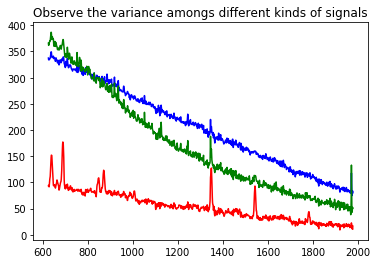

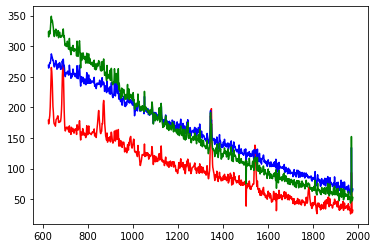

In [2]:
#Reading the data and interpolating according to the inputs of the DEEP CNN
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

directory = os.getcwd()
directory = os.path.join(os.getcwd(), 'dataset')
#dtypes managed later in the python notebook.
Ramandata_Raw = np.ones((1, 1351), dtype='object')
Diabetes = np.ones((1,), dtype='object') 

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        #reading raw file using pandas
        print(filename)
        filename = os.path.join(directory, filename)
        rawfile = pd.read_csv(filename)
        #converting to numpy array
        ramandata1 = np.asarray(rawfile)
        Ramandata_temp = ramandata1[1:, 1:] 
        
        Ramandata_Raw=np.append(Ramandata_Raw,Ramandata_temp[:,801-175:1802+175],axis=0)
        Diabetes = np.append(Diabetes,Ramandata_temp[0:, 0])
        
        
Ramandata_Raw = Ramandata_Raw[1:]
Diabetes = Diabetes[1:]      

Raman_shift = np.arange(626, 1977)

plt.title('Observe the variance amongs different kinds of signals')
plt.plot(Raman_shift, Ramandata_Raw[3], 'r', Raman_shift, Ramandata_Raw[23], 'b', Raman_shift, Ramandata_Raw[43], 'g')
plt.show()
plt.plot(Raman_shift, Ramandata_Raw[19], 'r', Raman_shift, Ramandata_Raw[39], 'b', Raman_shift, Ramandata_Raw[59], 'g')
plt.show()

# randomly shuffling the signals for easier cross validation
Diabetes = Diabetes.reshape(80, 1)
shufflematrix = np.append(Ramandata_Raw, Diabetes, axis=1)
# Ramandata2=np.take(shufflematrix,np.random.permutation(shufflematrix.shape[0]),axis=0)
np.random.shuffle(shufflematrix)

Ramandata_Raw_final = shufflematrix[:, :Ramandata_Raw.shape[1]]
Diabetes_final = shufflematrix[:, Ramandata_Raw.shape[1]]



# interpolation of data to be compliant with input size of the network

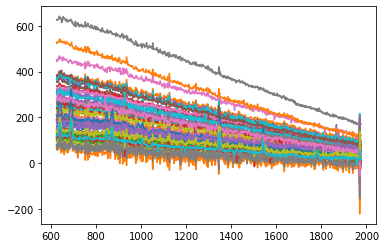

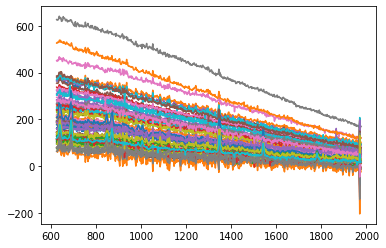

In [3]:
from scipy.interpolate import interp1d
f = interp1d(Raman_shift,Ramandata_Raw_final,kind='linear')

x = Raman_shift
y = Ramandata_Raw_final

# Interpolating onto the following set of points
New_Raman_shift = np.arange(626, 1977, 1.9285)
xnew = New_Raman_shift
ynew = f(xnew)
for i in range(Ramandata_Raw_final.shape[0]):
    plt.plot(x, y[i])
plt.show()
for i in range(Ramandata_Raw_final.shape[0]):
    plt.plot(xnew, ynew[i])
plt.show()


In [4]:
# Loading the data points 
X = f(xnew)
Y = Diabetes_final
print(X.shape, Y.shape)
nchannels = 1
rows = X.shape[1]

## Loading the train test and validation data and reshaping it for the Neural Network
#Reshaping the DATA for training

x_train = X.astype('float32')
x_train = x_train.reshape((-1, nchannels, rows))
targets_train = Y.astype('int32')

print("Information on dataset")
print("X_train shape : ", x_train.shape)
print("Y shape : ", Y.shape)
print("X dtype, Y dtype :", x_train.dtype, targets_train.dtype)


(80, 701) (80,)
Information on dataset
X_train shape :  (80, 1, 701)
Y shape :  (80,)
X dtype, Y dtype : float32 int32


# Transfer Learning

In [5]:
#Loading the pre trained network as a dictionary
model = torch.load('DEEP_CNN_TRAINEDMODEL/Final_Model.pth')

In [6]:
num_classes = 2
channels = x_train.shape[1]
height = x_train.shape[2]

num_filters_conv1 = 16
kernel_size_conv1 = 21 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 0

num_filters_conv2 = 32
kernel_size_conv2 = 11
stride_conv2 = 1
padding_conv2 = 0

num_filters_conv3 = 64
kernel_size_conv3 = 5
stride_conv3=1
padding_conv3=0

kernel_size_pooling1 = 2
stride_pooling1 = 2
padding_pooling1 = 0

#num_l1 = 2048
def compute_conv_dim(dim_size, k, p, s):
    return int((dim_size - k + 2 * p) / s + 1)

def compute_pool_dim(dim_size, kp, pp, sp):
    return int((dim_size - kp + 2 * pp) / sp + 1)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             padding=padding_conv1,
                             stride=stride_conv1)
        torch.nn.init.normal_(self.conv_1.weight,mean=0,std=0.22)
        self.conv_1_bn = BatchNorm1d(num_filters_conv1)
        self.maxpool_1 = MaxPool1d(kernel_size=kernel_size_pooling1,
                                   stride=stride_pooling1)
        
        self.conv_height1 = compute_pool_dim(compute_conv_dim(height,kernel_size_conv1,
                                                                  padding_conv1,stride_conv1)
                                                 ,kernel_size_pooling1,
                                                padding_pooling1,stride_pooling1)

        self.l1_in_features = num_filters_conv1 * self.conv_height1
        
        self.l_output = Linear(in_features=self.l1_in_features, 
                          out_features=num_classes,
                          bias=True)
        torch.nn.init.normal_(self.l_output.weight,mean=0,std=0.22)
        
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = leaky_relu(self.conv_1_bn(self.conv_1(x)))
        x = self.maxpool_1(x)
                                                                   
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor, but of a different size.
        # the size -1 is inferred from other dimensions 
        x = x.view(-1, self.l1_in_features)
        return softmax(self.l_output(x), dim=1)


net = Net()
print(net)


Net(
  (conv_1): Conv1d(1, 16, kernel_size=(21,), stride=(1,))
  (conv_1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_output): Linear(in_features=5440, out_features=2, bias=True)
)


In [7]:
# Copying the gradients and freezing the first layer(since we are using it as a readymade feature extractor)
params1 = net.named_parameters()
for name,param in params1:
    #print(name)
    #print(param)
    if name in model:
        param.data.copy_(model[name])
        param.requires_grad=False

In [8]:
params1=net.named_parameters()
for i in params1:
    print(i)

('conv_1.weight', Parameter containing:
tensor([[[ 2.8779e-01,  3.6881e-01,  2.2532e-01,  3.6725e-02,  3.1954e-01,
          -4.9127e-01, -6.6565e-02,  1.7382e-01,  1.3539e-01, -5.3819e-02,
          -2.8772e-01, -2.6729e-01, -3.7453e-01,  2.0567e-01,  3.3523e-01,
          -1.2135e-01,  2.2491e-01,  1.3332e-01,  1.1066e-01,  1.9777e-01,
          -5.7819e-02]],

        [[-3.0964e-01,  1.3295e-01,  3.5104e-01,  7.3997e-02,  9.5765e-02,
           4.6350e-02,  1.4048e-01,  1.0744e-01,  4.4464e-02,  2.9399e-01,
          -3.9970e-01,  4.6720e-01,  6.9200e-03,  2.7505e-02,  2.1209e-01,
           1.0701e-01, -2.8373e-02, -4.5751e-02, -1.7434e-01,  1.6801e-01,
           2.0354e-01]],

        [[ 1.6943e-01,  3.8605e-01,  1.9168e-01, -1.8755e-01,  1.7457e-01,
          -3.4220e-01,  1.9886e-01,  1.8397e-02,  1.7045e-01,  3.4344e-02,
           4.8345e-02, -2.4232e-01, -3.7524e-03, -1.4967e-01, -3.5415e-01,
          -3.0091e-02, -2.4912e-02, -2.8909e-01, -5.2792e-01, -1.0561e-01,
        

In [9]:
net.l_output.bias.requires_grad

True

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
#Testing Forward Pass
x = np.random.normal(0,1, (5, 1, 701)).astype('float32')
#print(x.shape)
out = net(Variable(torch.from_numpy(x)))
print(out.size(), out)
print("The forward pass is working just fine")

print("---------------TRAINING STARTS---------------")

torch.Size([5, 2]) tensor([[9.7987e-01, 2.0135e-02],
        [6.1234e-05, 9.9994e-01],
        [9.9972e-01, 2.8329e-04],
        [9.9921e-01, 7.9124e-04],
        [5.9624e-01, 4.0376e-01]], grad_fn=<SoftmaxBackward>)
The forward pass is working just fine
---------------TRAINING STARTS---------------


In [12]:
from sklearn.metrics import accuracy_score
def train_model(x_train,x_valid,targets_train,targets_valid,epochsnum):
    batch_size = 8
    num_epochs = epochsnum
    num_samples_train = x_train.shape[0]
    num_batches_train = int(np.ceil(num_samples_train / float(batch_size)))
    num_samples_valid = x_valid.shape[0]
    num_batches_valid = int(np.ceil(num_samples_valid / float(batch_size)))

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    test_acc, test_loss = [], []
    cur_loss = 0
    losses = []
    losses_train=[]
    losses_valid = []


    #creating a numpy array to store the output probabilities
    output_probs=np.ones((1,3),dtype=np.float32)

    #get_slice = lambda i, size,num_samples: range(i * size, (i + 1) * size)
    get_slice = lambda i, size, num_samples: range(i * size, np.minimum((i + 1) * size,num_samples))
    for epoch in range(num_epochs):
        cur_loss = 0
        net.train()
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size, num_samples_train)
            x_batch = Variable(torch.from_numpy(x_train[slce]))
            output = net(x_batch)

            # compute gradients given loss
            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            cur_loss += batch_loss.data.numpy()   
        losses.append(cur_loss / num_batches_train)

        net.eval()
        #Evaluating training
        train_preds, train_targs = [], []
        cur_loss=0
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size, num_samples_train)
            x_batch = Variable(torch.from_numpy(x_train[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            train_targs += list(targets_train[slce])
            train_preds += list(preds.data.numpy())

            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)

            cur_loss += batch_loss.data.numpy()
        losses_train.append(cur_loss / num_batches_train)

        ### Evaluate validation
        val_preds, val_targs = [], []
        cur_loss = 0
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size, num_samples_valid)
            x_batch = Variable(torch.from_numpy(x_valid[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            val_preds += list(preds.data.numpy())
            val_targs += list(targets_valid[slce])

            target_batch = Variable(torch.from_numpy(targets_valid[slce]).long())
            batch_loss = criterion(output, target_batch)         
            cur_loss += batch_loss.data.numpy()
        losses_valid.append(cur_loss / num_batches_valid)


            #Taking the output probabilities and storing them in a numpy array
            #output_probs=np.append(output_probs,output.data.numpy(),axis=0)

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

    epoch = np.arange(len(train_acc))
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Acc', 'Val Acc'])
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.show()

    plt.figure()
    plt.plot(losses_train,'r')
    plt.plot(losses_valid,'b')
    plt.legend(['Train','Valid'])
    plt.show()
    return (val_targs,val_preds,losses_train,losses_valid)

In [13]:
#AUC and ROC plot
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Net(
  (conv_1): Conv1d(1, 16, kernel_size=(21,), stride=(1,))
  (conv_1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_output): Linear(in_features=5440, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[9.9323e-01, 6.7708e-03],
        [1.8907e-01, 8.1093e-01],
        [3.8006e-02, 9.6199e-01],
        [1.5877e-04, 9.9984e-01],
        [9.9891e-01, 1.0932e-03]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.734768 , Train acc 0.539683, Valid acc 0.529412
Epoch 11 : Train Loss 0.601242 , Train acc 0.682540, Valid acc 0.411765
Epoch 21 : Train Loss 0.561107 , Train acc 0.746032, Valid acc 0.470588
Epoch 31 : Train Loss 0.538330 , Train acc 0.793651, Valid acc 0.529412
Epoch 41 : Train Loss 0.521464 , Train acc 0.793651, Valid acc 0.529412
Epoch 51 : Train Loss 0.507391 , Train acc 0.809524, Valid acc 0.588235
Epoch 61 : Train Loss

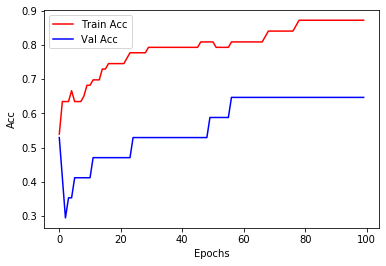

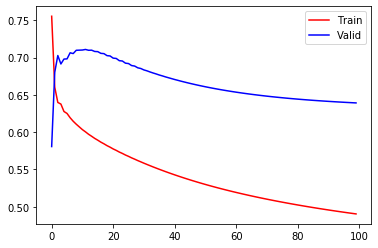

[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Net(
  (conv_1): Conv1d(1, 16, kernel_size=(21,), stride=(1,))
  (conv_1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_output): Linear(in_features=5440, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[2.2346e-07, 1.0000e+00],
        [1.3174e-07, 1.0000e+00],
        [3.9069e-10, 1.0000e+00],
        [1.0934e-07, 1.0000e+00],
        [1.9548e-11, 1.0000e+00]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.766294 , Train acc 0.546875, Valid acc 0.562500
Epoch 11 : Train Loss 0.676213 , Train acc 0.593750, Valid acc 0.375000
Epoch 21 : Train Loss 0.655988 , Train acc 0.593750, Valid acc 0.375000
Epoch 31 : Train Loss 0.64253

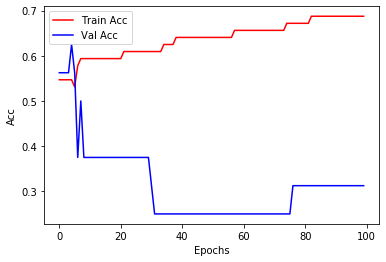

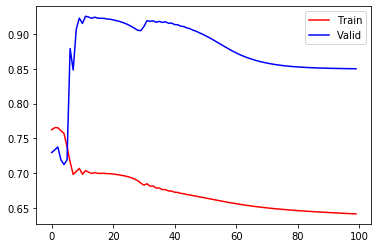

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
[0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
Net(
  (conv_1): Conv1d(1, 16, kernel_size=(21,), stride=(1,))
  (conv_1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_output): Linear(in_features=5440, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[1.7496e-02, 9.8250e-01],
        [9.7947e-01, 2.0528e-02],
        [9.9552e-01, 4.4797e-03],
        [9.9438e-01, 5.6232e-03],
        [2.2730e-04, 9.9977e-01]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.860041 , Train acc 0.453125, Valid acc 0.437500
Epoch 11 : Train Loss 0.690785 , Train acc 0.609375, Valid acc 0.500000
Epoch 21 : 

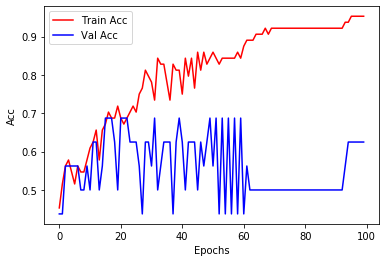

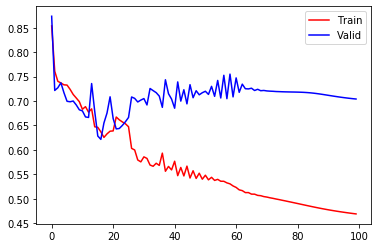

[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Net(
  (conv_1): Conv1d(1, 16, kernel_size=(21,), stride=(1,))
  (conv_1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_output): Linear(in_features=5440, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[9.9180e-01, 8.1998e-03],
        [2.2456e-04, 9.9978e-01],
        [1.0788e-01, 8.9212e-01],
        [9.9698e-01, 3.0240e-03],
        [4.0719e-03, 9.9593e-01]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.829116 , Train acc 0.468750, Valid 

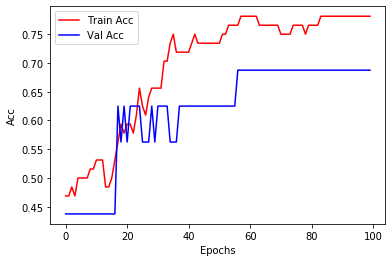

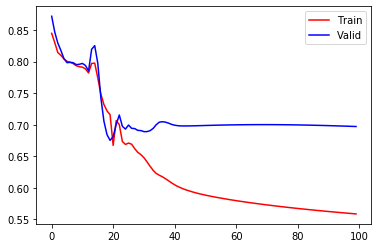

[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Net(
  (conv_1): Conv1d(1, 16, kernel_size=(21,), stride=(1,))
  (conv_1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_output): Linear(in_features=5440, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[9.4136e-01, 5.8638e-02],
        [3.0715e-05, 9.9997e-01],
        [9.9995e-01, 4.7429e-05],
        [2.9087e-06, 1.0000e+00],
        [2.6911e-02, 9.7309e-01]], grad

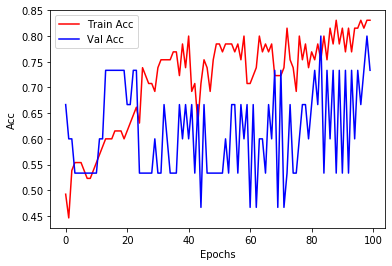

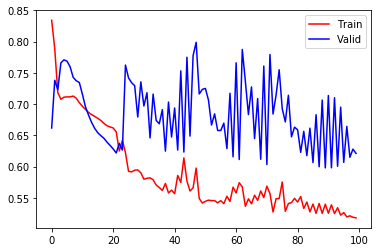

[0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


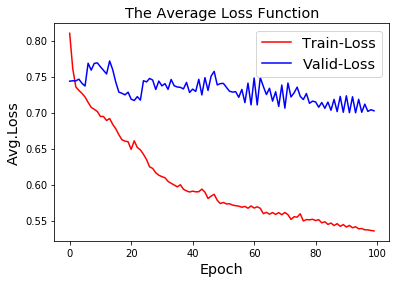

0.6


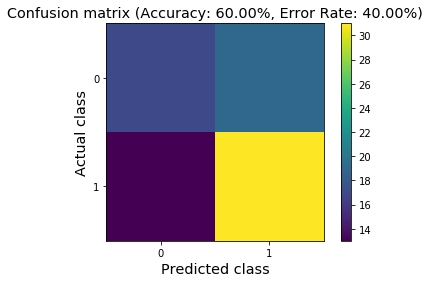

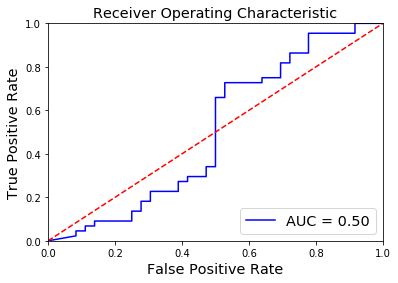

In [15]:
cv=StratifiedKFold(n_splits=5)
Validation_Targets=[]
Validation_Preds=[]
Total_Loss_Train=np.zeros(100)
Total_Loss_Valid=np.zeros(100)
All_Probabilities=[]
for train,test in cv.split(x_train,targets_train):
    Train_Data=x_train[train]
    Train_targets=targets_train[train]
    Test_Data=x_train[test]
    Test_targets=targets_train[test]
    
    net=Net()
    print(net)
    
    #Transfering weights here
    params1=net.named_parameters()
    for name,param in params1:
        #print(name)
        #print(param)
        if name in model:
            param.data.copy_(model[name])
            param.requires_grad=False
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=0.01)

    x = np.random.normal(0,1, (5, 1, 701)).astype('float32')
    #print(x.shape)
    out = net(Variable(torch.from_numpy(x)))
    print(out.size(), out, out.dtype)
    val_targs,val_preds,losses_train,losses_valid=train_model(Train_Data,Test_Data,Train_targets,Test_targets,100)
    print(val_preds)
    print(val_targs)
    Validation_Targets += list(val_targs)
    Validation_Preds += list(val_preds)
    print(Validation_Targets) 
    print(Validation_Preds) 
    Losses_Train_Array=np.asarray(losses_train)
    Losses_Valid_Array=np.asarray(losses_valid)
    Total_Loss_Train = Total_Loss_Train + Losses_Train_Array
    Total_Loss_Valid = Total_Loss_Valid + Losses_Valid_Array
    Preds_Probabilities=net(Variable(torch.from_numpy(Test_Data))).data.numpy()
    All_Probabilities += list(Preds_Probabilities[:,1])

plt.figure()
plt.title('The Average Loss Function',fontsize='x-large')
plt.plot(Total_Loss_Train/5,'r')
plt.plot(Total_Loss_Valid/5,'b')
plt.xlabel('Epoch',fontsize='x-large')
plt.ylabel('Avg.Loss',fontsize='x-large')
plt.legend(['Train-Loss','Valid-Loss'],fontsize='x-large')
plt.savefig('Images/LossFunction_CNN_TransferLearning.png')
plt.show()

print(accuracy_score(Validation_Targets,Validation_Preds))

from sklearn.metrics import confusion_matrix

C=num_classes
cm = confusion_matrix(Validation_Targets, Validation_Preds);
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
plt.figure(2);
plt.imshow(cm, interpolation='None');
plt.colorbar()
plt.xticks(range(C)); plt.yticks(range(C));
plt.xlabel('Predicted class',fontsize='x-large'); plt.ylabel('Actual class',fontsize='x-large');
plt.title('Confusion matrix (Accuracy: {:4.2f}%, Error Rate: {:4.2f}%)'.format(accuracy, error_rate),fontsize='x-large');
plt.savefig('Images/ConfusionMatrix_CNN_TransferLearning.png')
plt.show()

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(X_test)
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Validation_Targets, All_Probabilities)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic',fontsize='x-large')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right',fontsize='x-large')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize='x-large')
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.savefig('Images/ROCCurve_CNN_TransferLearning.png')
plt.show()

    

In [16]:
cm


array([[17, 19],
       [13, 31]])